https://www.youtube.com/watch?v=gKspuNylqrs&list=LL

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np
import rasterio
from scipy.interpolate import griddata
from rasterio.transform import Affine
from rasterio.crs import CRS
import interpies
import module_gmf
# from grid import Grid, from_dataset

In [2]:
def set_map(ax, frame=True):
    ax.invert_yaxis()
    ax.ticklabel_format(useOffset=False, style='plain')

    ax.xaxis.label.set_fontsize(10)
    ax.yaxis.label.set_fontsize(10)
    ax.set_xlabel('Easting')
    ax.set_ylabel('Northing')
    ax.tick_params(axis='x', labelsize=8, rotation=0)
    ax.tick_params(axis='y', labelsize=8, rotation=0)

    start, end = ax.get_ylim()
    start = (round(start, -3))
    ax.yaxis.set_ticks(np.arange(start, end, 2000))

    start, end = ax.get_xlim()
    start = (round(start, -3))
    ax.xaxis.set_ticks(np.arange(start, end, 2000))

    if frame == False:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')

In [3]:
def main(i, df, file_output):
    points = list(zip(df['X'], df['Y']))
    values = df[i].values

    min_x = df['X'].min()
    max_x = df['X'].max()
    min_y = df['Y'].min()
    max_y = df['Y'].max()

    res1 = (max_x - min_x)/1000
    res2 = (max_y - min_y)/1000

    xrange = np.arange(min_x, max_x + res1, res1)
    yrange = np.arange(min_y, max_y + res2, res2)
    gridx, gridy = np.meshgrid(xrange, yrange)
    grid_grav = griddata(points, values, (gridx, gridy), method='cubic', fill_value=np.nan)

    grid_grav = module_gmf.mask_area(grid_grav, gridx, gridy)

    # fig, ax = plt.subplots()
    # im = ax.imshow(grid_grav, extent=(min_x, max_x, min_y, max_y), origin='lower')
    # ax.plot(df['X'], df['Y'], 'bo')
    # ax.ticklabel_format(useOffset=False, style='plain')

    rasterCRS = CRS.from_epsg(32748)
    transform = Affine.translation(gridx[0][0]-res1/2, gridy[0][0]-res2/2)*Affine.scale(res1, res2)

    rasterfile = rasterio.open(
                                file_output, 'w', 
                                driver='GTiff',
                                dtype=grid_grav.dtype, 
                                count=1, 
                                width=grid_grav.shape[1], 
                                height=grid_grav.shape[0],
                                transform=transform,
                                crs=rasterCRS
                            )

    rasterfile.write(grid_grav, indexes=1)
    rasterfile.close()

    grid1 = interpies.open(file_output)

    ax1 = grid1.smooth(method='SG', deg=1, win=21, doEdges=True, sigma=1)
    ax1 = ax1.show(
                    cmap_norm='equalize', 
                    contours=True, 
                    azdeg=45, altdeg=45, 
                    # title='',
                    # zf=1000,
                    figsize=(10, 10)
                    )
    set_map(ax1, frame=False)
    
    # [50, 100, 200, 300, 400, 500, 1000,2000,3000,4000,5000]

    z = [1500]
    for i in z:
        ax1 = grid1.hp_filter_uc(z=i)
        # ax1 = ax1.dxdy(
        #                 method='SG', 
        #                 deg=3, 
        #                 win=5, 
        #                 doEdges=True, 
        #                 fs_tap=5
        #                 )
        ax1 = ax1.smooth(method='SG', deg=1, win=21, doEdges=True, sigma=1)
        ax1 = ax1.show(
                        cmap_norm='equalize', 
                        contours=True, 
                        azdeg=45, altdeg=45, 
                        # title=False, 
                        # zf=1000,
                        figsize=(10, 10)
                        )
        
        set_map(ax1, frame=False)
    
    for i in z:
        ax1 = grid1.up(z=i)
        # ax1 = ax1.dxdy(
        #                 method='SG', 
        #                 deg=i, 
        #                 win=21, 
        #                 doEdges=True, 
        #                 fs_tap=5
        #                 )
        ax1 = ax1.show(
                        cmap_norm='equalize', 
                        contours=True, 
                        azdeg=45, altdeg=45, 
                        # title=False, 
                        # zf=1000,
                        figsize=(10, 10)
                        )
        set_map(ax1, frame=False)
        # ax1.save(file_output)

    # ax1.plot(df['X'], df['Y'], color='black', linestyle='None', marker='+', markersize=2, alpha=0.5)

    
    


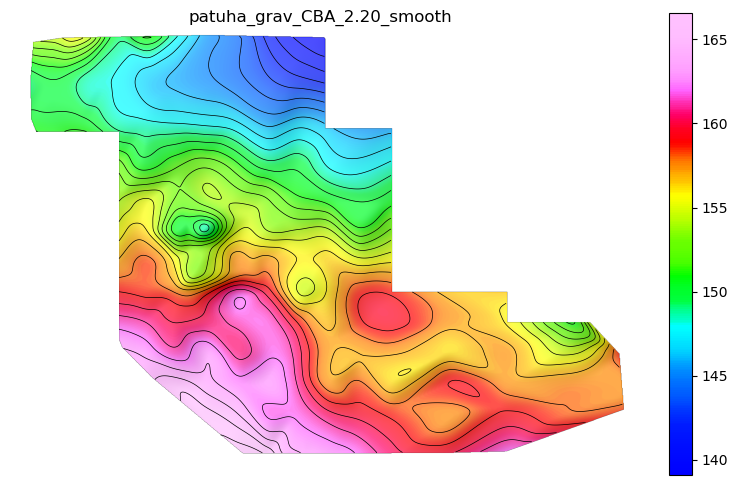

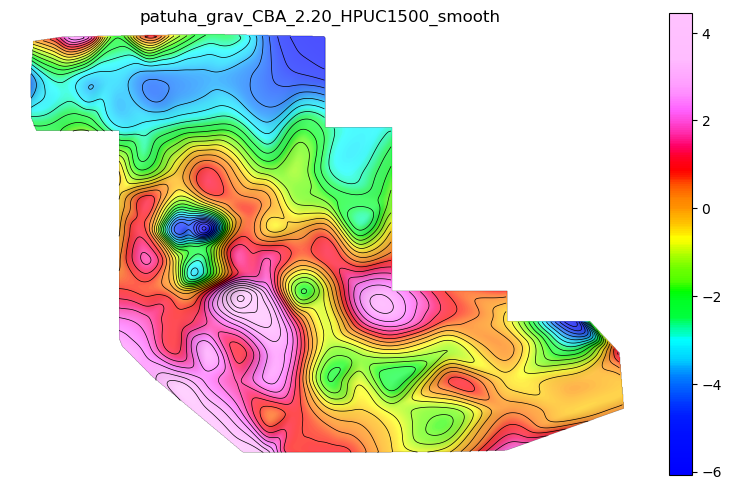

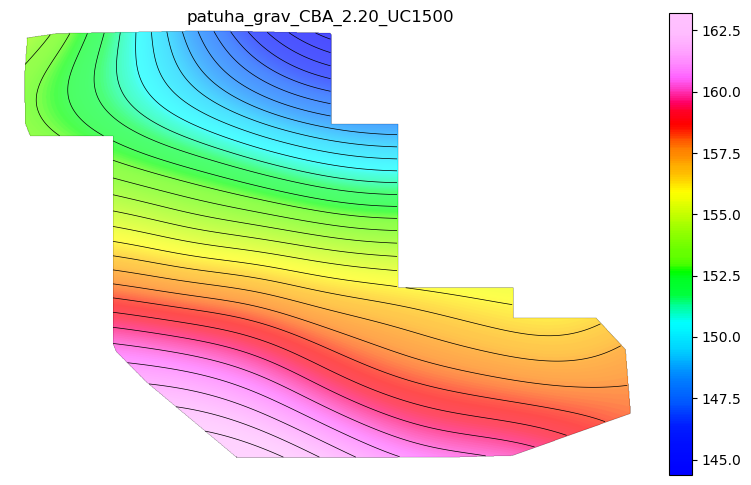

In [4]:
data_file = '../data/data.xlsx'
file_output_prefix = '../map/patuha_grav_'

df = pd.read_excel(data_file, header=0)
# print(df.columns)

gen_maps = [
#     'Z','Gobs', 'FAA',
    # 'CBA_1.00', 'CBA_2.20', 'CBA_2.30', 'CBA_2.48', 'CBA_2.65', 'CBA_2.77'

    'CBA_2.20'
]

for i in gen_maps:
    file_output = file_output_prefix + i + '.tiff'
    main(i, df, file_output)